In [1]:
import pathlib
import pandas as pd

In [2]:
data_path = pathlib.Path('./time_series')

In [6]:
df = pd.DataFrame()
for f in data_path.iterdir():
    if f.name.endswith('.csv'):
        place = f.name.split('_')[-1][:-4]
        temp = pd.read_csv(f, parse_dates=['week']).set_index('week').rename(columns={'value': place})
        df = pd.concat([df, temp], axis=1)

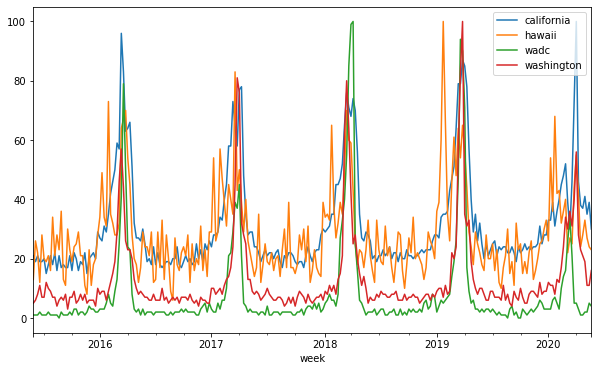

In [4]:
df.plot(figsize=(10,6));

## 2020 Prediction w/ Vanilla Prophet for WA State

In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet()
X = df['washington'].reset_index().rename(columns={'week': 'ds', 'washington': 'y'})
X_train = X[X['ds'] < '2020']
X_test = X[X['ds'] >= '2020']

In [192]:
m.fit(X_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
pred = m.predict(X_test[['ds']])[['ds', 'yhat']].set_index('ds')

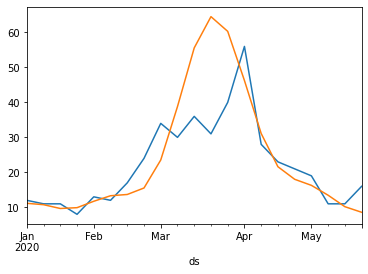

In [194]:
X_test.set_index('ds')['y'].plot();
pred['yhat'].plot();

In [195]:
print('error:', sum((X_test.set_index('ds')['y'] - pred['yhat'])**2))

error: 2383.0262932387686


## 2020 Prediction w/ SVD + Vanilla Prophet for WA State

In [ ]:
from sklearn.decomposition import TruncatedSVD as SVD

In [199]:
svd = SVD(n_components=2)
X_t = svd.fit_transform(df.loc[:'2019'])
sum(svd.explained_variance_ratio_)

0.8956005816407587

In [ ]:
X_t = pd.DataFrame(X_t, index=df.loc[:'2019'].index)

In [ ]:
X_0 = X_t[0].reset_index().rename(columns={'week': 'ds', 0: 'y'})
X_1 = X_t[1].reset_index().rename(columns={'week': 'ds', 1: 'y'})

In [202]:
m_0 = Prophet().fit(X_0)
m_1 = Prophet().fit(X_1)
pred_0 = m_0.predict(X_test[['ds']])[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'yhat_0'})
pred_1 = m_1.predict(X_test[['ds']])[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'yhat_1'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
pred_t = pd.concat([pred_0, pred_1], axis=1)

In [ ]:
pred = svd.inverse_transform(pred_t)

In [ ]:
pred_df = pd.DataFrame(pred, columns=df.columns, index = df.loc['2020'].index)

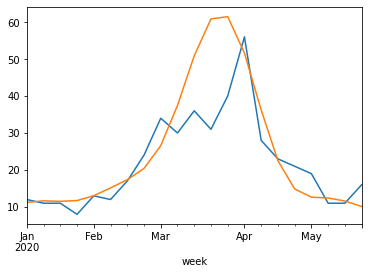

In [206]:
df.loc['2020']['washington'].plot()
pred_df.loc['2020']['washington'].plot()

In [210]:
print('error:', sum((df.loc['2020']['washington'] - pred_df.loc['2020']['washington'])**2))

error: 1924.9001407422704
